# Road Extraction
Members: Dazhao Lao(dl4379)  

---
Inspired by Google Maps, this project aims to extract roads from high-resolution remote sensing images in the project, which may help update the map automatically. The dataset used by this project is [Massachusetts Roads Dataset](https://www.cs.toronto.edu/~vmnih/data/), which have label the road in the high-resolution remote sensing images.  
The project will use DeepLab V3+ and RefineNet to extract roads from high-resolution remote sensing images separately.


In [ ]:
#import data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# import packages
import os
from pprint import pprint
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('/content/drive/MyDrive/Road/Semantic_Segmentation_Keras-master')
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.utils.vis_utils import plot_model

from core.nets import SemanticSegmentationModel
from core.utils.data_utils.data_generator import ImageDataGenerator
from core.utils.metric_utils import compute_global_metrics

### DeepLab V3+

DeepLab V3+ was proposed by the Google team in 2018. In order to integrate multi-scale information, the encoder-decoder, which is commonly used in semantic segmentation, is introduced to improve the segmentation results of object edges.  
Moreover, in the encoder-decoder architecture, the resolution of the feature extracted by the encoder can be arbitrarily controlled, and the accuracy and time-consuming are balanced through dilated convolution.  
In addition, it also tried to use Xception as an encoder. Xception is an improvement of Inception V3 proposed by google. It mainly uses depthwise separable convolution to replace the convolution operation in Inception V3, which allows us to get a faster network with higher precision.  
The picture below shows the architecture of DeepLab V3+:   

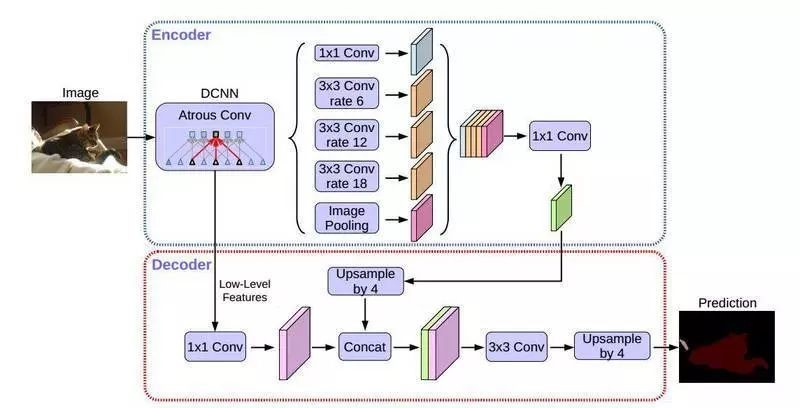

##### Prepare dataset

In [ ]:
# get training and validation sample names
with open('/content/drive/MyDrive/Road/Data_2/train.txt',"r",encoding="utf-8") as f:
    train_base_fnames = [line.strip() for line in f]
with open('/content/drive/MyDrive/Road/Data_2/val.txt',"r",encoding="utf-8") as f:
    val_base_fnames = [line.strip() for line in f]
n_train, n_val = len(train_base_fnames), len(val_base_fnames)
batch_size = 5
steps_per_epoch = n_train // batch_size
steps_per_epoch_val = n_val // batch_size

##### Build the DeepLab V3+ model

In [ ]:
model_deeplab = SemanticSegmentationModel(model_name='deeplab_v3p',
                  input_shape=(512,512,3),
                  n_class=2,
                  encoder_name='xception_41',
                  init_filters=64,
                  dropout=0.5,
                  weight_decay=1e-4)

plot_model(model_deeplab, "/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5".replace(".h5", ".png"), show_shapes=True)
model_deeplab.summary()
model_deeplab.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print("training data size = %d" % n_train)
print("validation data size = %d" % n_val)
print("training iteration/epoch = %d" % steps_per_epoch)
print("validation iteration/epoch = %d" % steps_per_epoch_val)
print("model save path: %s" % "/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5")



Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 512, 512, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
entry_block1_conv1 (Conv2D)     (None, 256, 256, 32) 864         batch_normalization_54[0][0]     
__________________________________________________________________________________________________
entry_block1_conv1_bn (BatchNor (None, 256, 256, 32) 128         entry_block1_conv1[0][0]         
___________________________________________________________________________________________

##### Training DeepLab V3+

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    #zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator()

callbacks = list()
callbacks.append(ModelCheckpoint("/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5",save_best_only=True,save_weights_only=True,verbose=1))
callbacks.append(TensorBoard(log_dir=os.path.join('/content/drive/MyDrive/Road/Deeplabv3p', 'logs')))

hist_deeplab = model_deeplab.fit_generator(
    generator=train_datagen.flow_from_directory(
        base_fnames=train_base_fnames,
        image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/MyDrive/Road/Data_2/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=False,
        dataset_name='Road'),
    validation_data=val_datagen.flow_from_directory(
        base_fnames=val_base_fnames,
        image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/MyDrive/Road/Data_2/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=False),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    epochs=30,
    callbacks=callbacks,
    verbose=1)

print("Training success!")

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.5446 - acc: 0.9573
Epoch 00001: val_loss improved from inf to 0.44805, saving model to /content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5
200/200 [==============================] - 687s 3s/step - loss: 0.5446 - acc: 0.9573 - val_loss: 0.4480 - val_acc: 0.9498
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.2591 - acc: 0.9622
Epoch 00002: val_loss improved from 0.44805 to 0.37124, saving model to /content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5
200/200 [==============================] - 250s 1s/step - loss: 0.2591 - acc: 0.9622 - val_loss: 0.3712 - val_acc: 0.9498
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.1777 - acc: 0.9658
Epoch 00003: val_loss improved from 0.37124 to 0.18748, saving model to /content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5
200/200 [==============================] - 250s 1s/step - loss: 0.1777 - acc: 0.9658 - val_loss: 0.1875 - val_ac

##### Predict
To see how DeepLab V3+ works, I will use a minibatch of validation data and display 5 images and the prediction map of them.

In [ ]:
model_deeplab = SemanticSegmentationModel(model_name='deeplab_v3p',
                  input_shape=(512,512,3),
                  n_class=2,
                  encoder_name='xception_41',
                  init_filters=64,
                  dropout=0.5,
                  weight_decay=1e-4)
model_deeplab.load_weights('/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5')

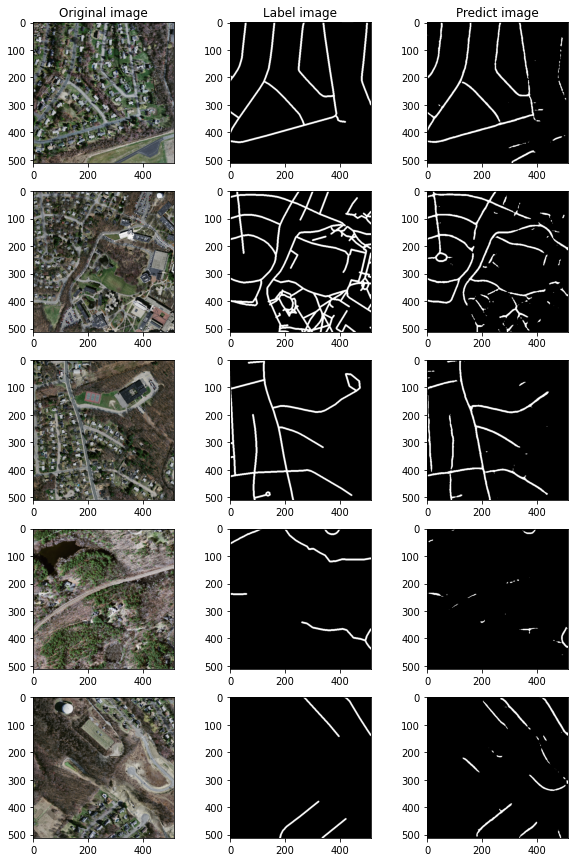

In [ ]:
val_generator = val_datagen.flow_from_directory(
          base_fnames=val_base_fnames,
          image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
          image_suffix='.tif',
          image_color_mode='rgb',
          label_dir='/content/drive/My Drive/Road/Data_2/target_maps',
          label_suffix='.tif',
          n_class=2,
          feed_onehot_label=False,
          cval=0,
          label_cval=0,
          crop_mode='none',
          target_size=(512,512),
          batch_size=batch_size,
          shuffle=False)
imgs,labels = val_generator.next()
preds_deeplab = model_deeplab.predict(imgs)
plt.figure(figsize=(10,15))
for i in range(5):
  img = imgs[i]/255
  ax1 = plt.subplot(5,3,i*3+1)
  plt.imshow(img)
  label = labels[i]
  ax2 = plt.subplot(5,3,i*3+2)
  plt.imshow(label,cmap='gray')
  pred = np.argmax(preds_deeplab[i], axis=-1)
  ax3 = plt.subplot(5,3,i*3+3)
  plt.imshow(pred,cmap='gray')
  if i == 0:
    ax1.set_title('Original image')
    ax2.set_title('Label image')
    ax3.set_title('Predict image')

##### Evaluate

In [67]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
with open('/content/drive/MyDrive/Road/Deeplabv3p/train_acc.csv')as f:
  f_csv = csv.reader(f)
  next(f_csv)
  for row in f_csv:
    train_acc.append(float(row[2]))
with open('/content/drive/MyDrive/Road/Deeplabv3p/train_loss.csv')as f:
  f_csv = csv.reader(f)
  next(f_csv)
  for row in f_csv:
    train_loss.append(float(row[2]))
with open('/content/drive/MyDrive/Road/Deeplabv3p/val_acc.csv')as f:
  f_csv = csv.reader(f)
  next(f_csv)
  for row in f_csv:
    val_acc.append(float(row[2]))
with open('/content/drive/MyDrive/Road/Deeplabv3p/val_loss.csv')as f:
  f_csv = csv.reader(f)
  next(f_csv)
  for row in f_csv:
    val_loss.append(float(row[2]))

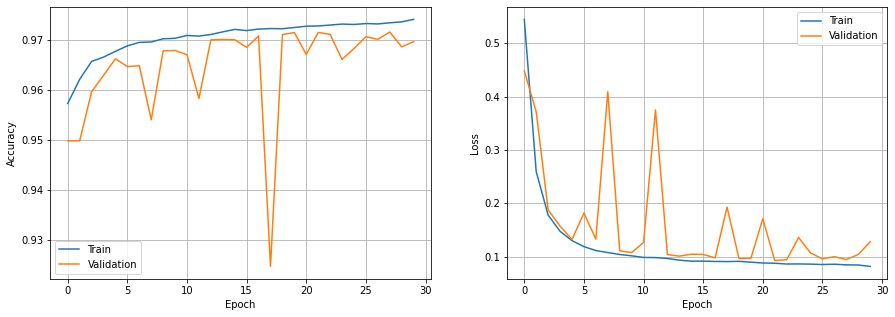

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(['Train','Validation'])

plt.subplot(1,2,2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(['Train','Validation'])

In [ ]:
n_class = 2
mat = np.zeros((n_class, n_class))

for i in range(steps_per_epoch_val):
  imgs,labels = val_generator.next()
  preds_deeplab = model_deeplab.predict(imgs)
  for j in range(batch_size):
    label = labels[j]
    pred = np.argmax(preds_deeplab[j], axis=-1)
    _mat = confusion_matrix(label.reshape(-1), pred.reshape(-1), labels=np.arange(n_class))
    mat = mat + _mat
avg_metric = compute_global_metrics(mat)
print('Confusion Matrix:\n',mat)
print('\nPrecision Indicators:')
for key in avg_metric:
    print('{:20s}{}'.format(key, avg_metric[key]))

Confusion Matrix:
 [[12290566.   158884.]
 [  295569.   362181.]]

Precision Indicators:
macro_avg_acc       0.7689369645555864
micro_avg_acc       0.9653279876708984
precisions          [0.9765163  0.69507835]
precision           0.962393085745789
recalls             [0.98723767 0.55063626]
recall              0.9653279876708984
f1s                 [0.98184772 0.61448319]
f1                  0.9638583025549102
ious                [0.9643427  0.44350468]
miou                0.7039236881470367


### RefineNet

RefineNet is a general multi-path optimized network proposed in 2016. Since the current deep convolutional network has outstanding performance in target recognition and image segmentation, but frequent downsampling loses the information of the original image, RefineNet clearly uses all the information available in the entire downsampling process and uses remote residual connection Achieve high-resolution predictions. In this way, the fine-grained features in the early convolution can be used to directly refine the deeper network layers that capture high-level semantic features. The various components of RefineNet use residual connections that follow the idea of ​​identity mapping, which allows the network to perform effective end-to-end training.
RefineNet solves the problem of reduced spatial resolution in traditional convolutional networks, which is very different from the method used by PSPNet (which uses a high computational cost of convolution with holes). The proposed architecture iterative pooling feature uses a special RefineNet module to increase different resolutions, and finally generates a high-resolution segmentation map. Therefore, it is very suitable for the task of road extraction in this research. The down-sampling convolutional layer used in the RefineNet network in this research is ResNet V2, with 50 layers.  
The picture below shows the architecture of RefineNet:  

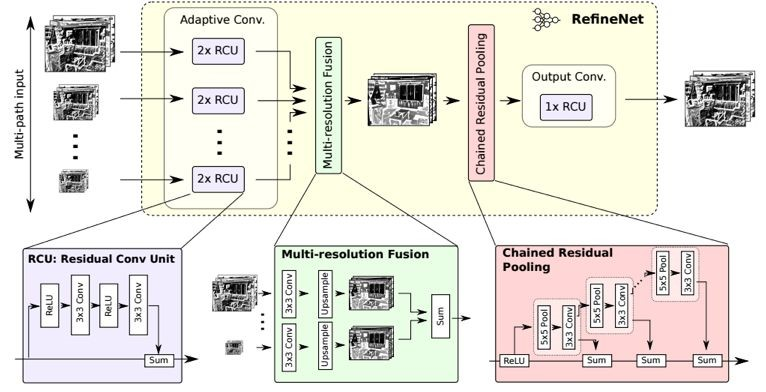

##### Build the RefineNet model

In [ ]:
model_refinenet = SemanticSegmentationModel(model_name='refinenet',
                  input_shape=(512,512,3),
                  n_class=2,
                  encoder_name='resnet_v2_50',
                  init_filters=64,
                  dropout=0.5,
                  weight_decay=1e-4)

plot_model(model_refinenet, "/content/drive/MyDrive/Road/Refinenet/refinenet.h5".replace(".h5",".png"), show_shapes=True)
model_refinenet.summary()
model_refinenet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print("training data size = %d" % n_train)
print("validation data size = %d" % n_val)
print("training iteration/epoch = %d" % steps_per_epoch)
print("validation iteration/epoch = %d" % steps_per_epoch_val)
print("model save path: %s" % "/content/drive/MyDrive/Road/Refinenet/refinenet.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9408        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv1[0][0]                      
__________

##### Training RefineNet

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,horizontal_flip=True)
val_datagen = ImageDataGenerator()

callbacks = list()
callbacks.append(ModelCheckpoint("/content/drive/MyDrive/Road/Refinenet/refinenet.h5",save_best_only=True,save_weights_only=True,verbose=1))
callbacks.append(TensorBoard(log_dir=os.path.join('/content/drive/MyDrive/Road/Refinenet', 'logs')))

hist_refinenet = model_refinenet.fit_generator(
    generator=train_datagen.flow_from_directory(
        base_fnames=train_base_fnames,
        image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/MyDrive/Road/Data_2/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=True,
        dataset_name='Road'),
    validation_data=val_datagen.flow_from_directory(
        base_fnames=val_base_fnames,
        image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/MyDrive/Road/Data_2/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=False),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    epochs=30,
    callbacks=callbacks,
    verbose=1)

print("Training success!")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30
200/200 [==============================] - 574s 3s/step - loss: 5.5449 - acc: 0.9446 - val_loss: 4.5837 - val_acc: 0.9485

Epoch 00001: val_loss improved from inf to 4.58372, saving model to /content/drive/MyDrive/Road/Refinenet/refinenet.h5

Epoch 2/30
200/200 [==============================] - 193s 965ms/step - loss: 3.7872 - acc: 0.9565 - val_loss: 3.0959 - val_acc: 0.9521

Epoch 00002: val_loss improved from 4.58372 to 3.09591, saving model to /content/drive/MyDrive/Road/Refinenet/refinenet.h5
Epoch 3/30
200/200 [==============================] - 192s 961ms/step - loss: 2.6836 - acc: 0.9595 - val_loss: 2.2548 - val_acc: 0.9519

Epoch 00003: val_loss improved from 3.09591 to 2.25477, saving model to /content/drive/MyDrive/Road/Refinenet/refinenet.h5
Epoch 4/30
200/200 [==============================] - 193s 963ms/step - loss: 2.0006 - acc: 0.9619 - val_loss: 1.6998 - val_acc: 

##### Predict

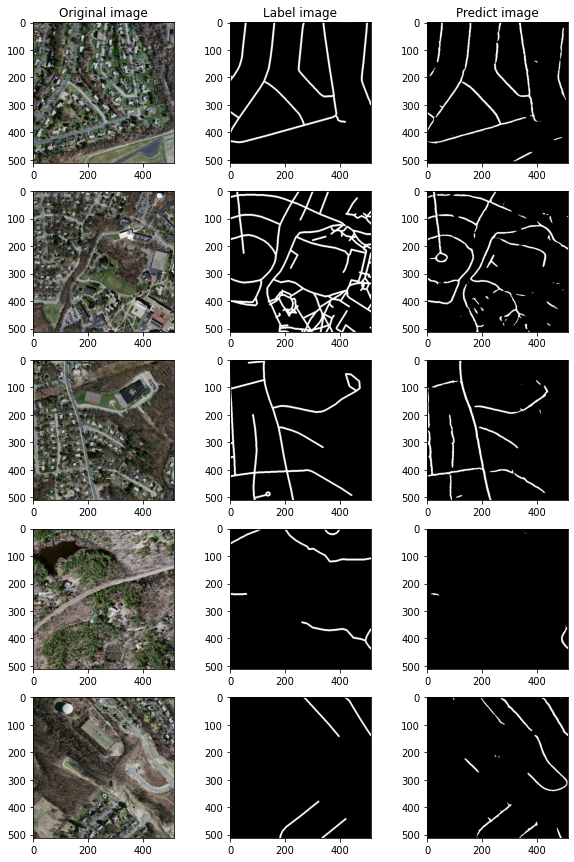

In [71]:
val_generator = val_datagen.flow_from_directory(
          base_fnames=val_base_fnames,
          image_dir='/content/drive/MyDrive/Road/Data_2/input_images',
          image_suffix='.tif',
          image_color_mode='rgb',
          label_dir='/content/drive/My Drive/Road/Data_2/target_maps',
          label_suffix='.tif',
          n_class=2,
          feed_onehot_label=False,
          cval=0,
          label_cval=0,
          crop_mode='none',
          target_size=(512,512),
          batch_size=batch_size,
          shuffle=False)
imgs,labels = val_generator.next()
preds_refinenet = model_refinenet.predict(imgs)
plt.figure(figsize=(10,15))
for i in range(5):
  img = imgs[i]/255
  ax1 = plt.subplot(5,3,i*3+1)
  plt.imshow(img)
  label = labels[i]
  ax2 = plt.subplot(5,3,i*3+2)
  plt.imshow(label,cmap='gray')
  pred = np.argmax(preds_refinenet[i], axis=-1)
  ax3 = plt.subplot(5,3,i*3+3)
  plt.imshow(pred,cmap='gray')
  if i == 0:
    ax1.set_title('Original image')
    ax2.set_title('Label image')
    ax3.set_title('Predict image')

##### Evaluate

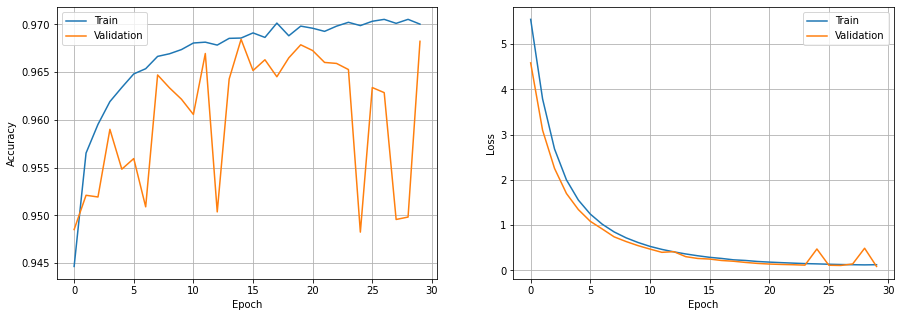

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_refinenet.history['acc'])
plt.plot(hist_refinenet.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(['Train','Validation'])

plt.subplot(1,2,2)
plt.plot(hist_refinenet.history['loss'])
plt.plot(hist_refinenet.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(['Train','Validation'])

In [ ]:
n_class = 2
mat = np.zeros((n_class, n_class))

for i in range(steps_per_epoch_val):
  imgs,labels = val_generator.next()
  preds_deeplab = model_refinenet.predict(imgs)
  for j in range(batch_size):
    label = labels[j]
    pred = np.argmax(preds_deeplab[j], axis=-1)
    _mat = confusion_matrix(label.reshape(-1), pred.reshape(-1), labels=np.arange(n_class))
    mat = mat + _mat
avg_metric = compute_global_metrics(mat)
print('Confusion Matrix:\n',mat)
print('\nPrecision Indicators:')
for key in avg_metric:
    print('{:20s}{}'.format(key, avg_metric[key]))

Confusion Matrix:
 [[12337826.   111624.]
 [  304874.   352876.]]

Precision Indicators:
macro_avg_acc       0.7637616842358463
micro_avg_acc       0.9682237243652344
precisions          [0.97588537 0.75968999]
precision           0.9650361818059887
recalls             [0.99103382 0.53648955]
recall              0.9682237243652343
f1s                 [0.98340126 0.62887235]
f1                  0.9666273252890244
ious                [0.96734456 0.4586534 ]
miou                0.7129989818039305


### Comparison

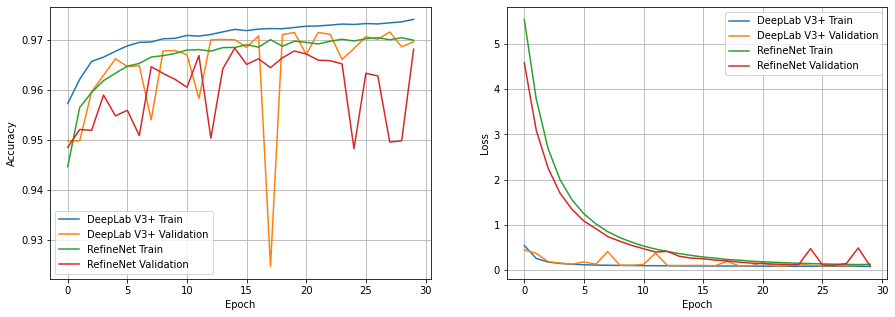

In [70]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(hist_refinenet.history['acc'])
plt.plot(hist_refinenet.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(['DeepLab V3+ Train','DeepLab V3+ Validation',
      'RefineNet Train','RefineNet Validation'])

plt.subplot(1,2,2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(hist_refinenet.history['loss'])
plt.plot(hist_refinenet.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(['DeepLab V3+ Train','DeepLab V3+ Validation',
      'RefineNet Train','RefineNet Validation'])

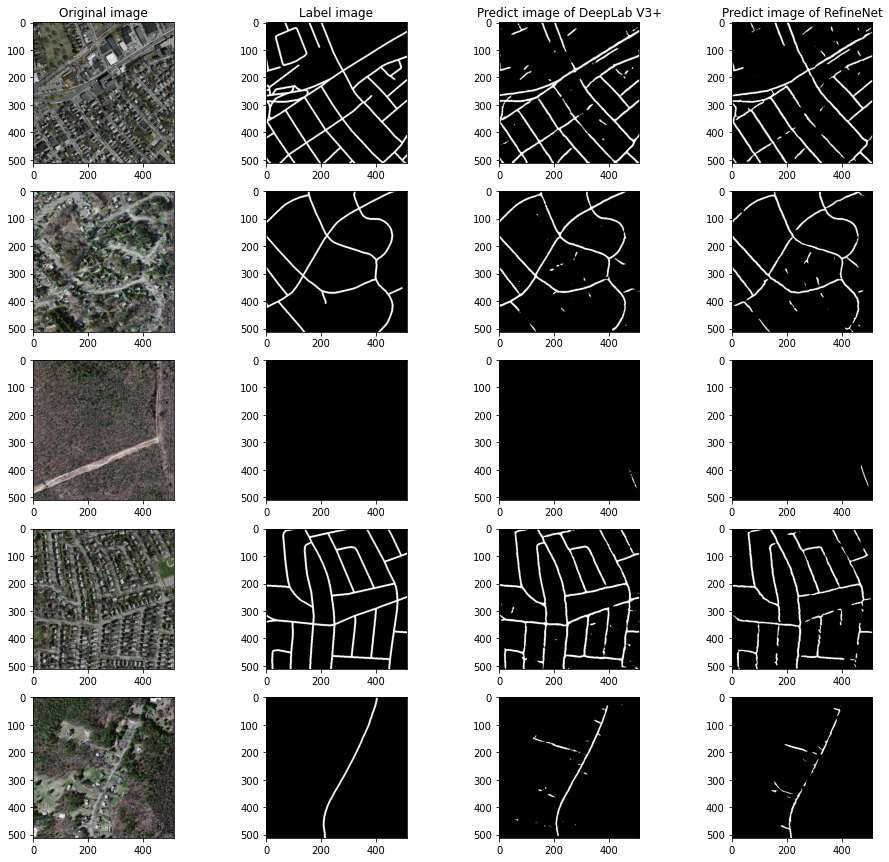

In [76]:
imgs,labels = val_generator.next()
preds_refinenet = model_refinenet.predict(imgs)
preds_deeplab = model_deeplab.predict(imgs)
plt.figure(figsize=(16,15))
for i in range(5):
  img = imgs[i]/255
  ax1 = plt.subplot(5,4,i*4+1)
  plt.imshow(img)

  label = labels[i]
  ax2 = plt.subplot(5,4,i*4+2)
  plt.imshow(label,cmap='gray')

  pred_d = np.argmax(preds_deeplab[i], axis=-1)
  ax3 = plt.subplot(5,4,i*4+3)
  plt.imshow(pred_d,cmap='gray')

  pred_r = np.argmax(preds_refinenet[i], axis=-1)
  ax4 = plt.subplot(5,4,i*4+4)
  plt.imshow(pred_r,cmap='gray')
  if i == 0:
    ax1.set_title('Original image')
    ax2.set_title('Label image')
    ax3.set_title('Predict image of DeepLab V3+')
    ax4.set_title('Predict image of RefineNet')


### Conclusion

This lab shows that the RefineNet and the DeepLab V3+ have excellent accuracy on the road extraction task. The extracted road structure is generally complete and the models have good adaptability, but the results are still a little blurry. Overall, it can effectively extract road from remote sensing images.

Among them, the accuracy of RefineNet is 0.9682, while that of DeepLab V3+ is 0.9716. So DeepLab V3+ performs better in this task.

Although the accuracy of the road extraction results in this project has reached 0.9716, due to the small data set used in this experiment, there are still some small road disconnection and some roads can not be identified or misjudged. Secondly, because part of the suburban roads is muddy roads, the color difference is large, which leads to the neural network model can not be well learned, resulting in the extraction results of suburbs are not as good as the city center, which needs to be improved in the future research.

Although deep learning has achieved high accuracy in road extraction, the current deep learning model still needs to rely on a large number of data sets for model training, and the establishment of data sets will undoubtedly cost a lot of manpower and material resources. Therefore, how to achieve high accuracy in unsupervised and weakly supervised deep learning is what I need to learn in the future.